### Типы задач при работе с последовательностями

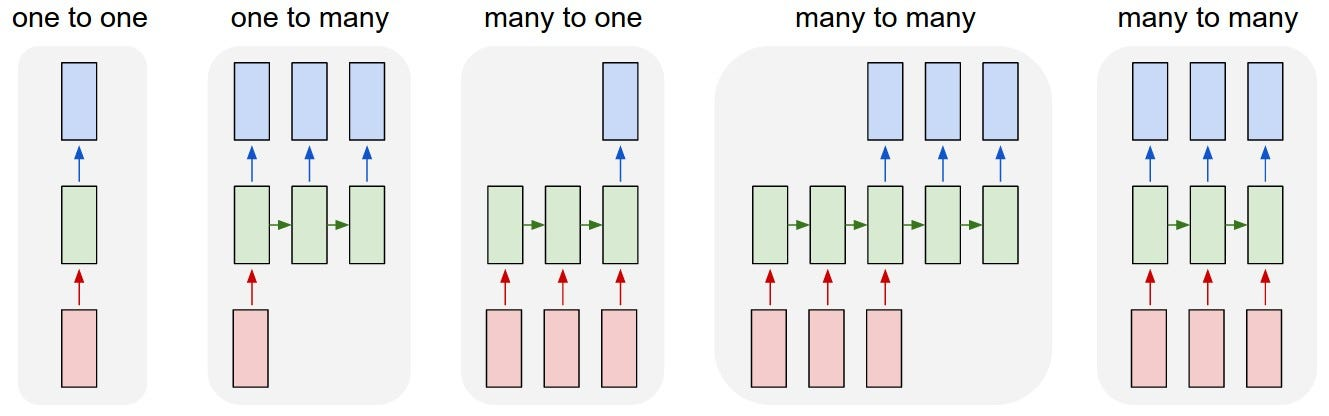



*  **One-to-one** - один вход и один выход. Это самый простой случай, под который подпадают такие задачи, как классификация изображений, где одно изображение соответствует одной метке.
*  **One-to-many** - один вход и несколько выходов. Пример задачи - генерация подписей для изображения.
* **Many-to-one** - типичный пример - классификация текстов.
* **Many-to-many** v1 - последовательности разной длины на входе и на выходе. Применяется в таких задачах, как машинный перевод, где предложение на одном языке переводится в предложение на другом языке, но, вероятно, с другим количеством токенов.
* **Many-to-many** v2 - последовательности одной длины на входе и на выходе. Применяется в таких задачах, как NER, POS-tagging, где каждому токену входа сопоставляется свой выход.



## Архитектура encoder-decoder для машинного перевода


![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

%matplotlib inline

## Машинный перевод

Попробуем решить задачу машинного перевода с русского на английский. В частности, будем работать с описаниями отелей.

Прежде чем перейти к  реализации архитектуры, необходимо выполнить некоторую предварительную обработку - токенизацию.

Данные содержат уникальные редкие слова. Если мы работаем на уровне слов, нам придется иметь дело с большим словарем. Если вместо этого мы будем использовать модели на уровне отдельных символов, для обработки последовательности потребуется много итераций. На этот раз мы выберем нечто среднее.

Один из популярных подходов называется [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) , также известный как BPE. Алгоритм начинается с токенизации на уровне символов, а затем итеративно объединяет наиболее часто встречающиеся пары в течение N итераций. Это приводит к тому, что часто встречающиеся слова объединяются в один токен, а редкие слова разбиваются на слоги или даже символы.




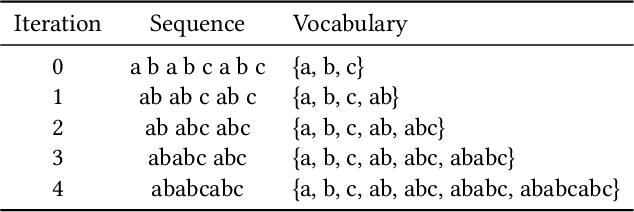

### Подгрузка данных

In [ ]:
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

--2025-03-06 20:49:09--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-03-06 20:49:09--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucefced7de5f501dec4f65f0f50f.dl.dropboxusercontent.com/cd/0/inline/ClZ0PMyQg18jNoDpmH3cIjOSJ9jHbN1Th6YYROVg0BmYu0VAOyHa4T7PuUP0tjdtDn6McQIwm99XoQpxAYAPK5SetINbkvMmTU4C5FxPVLd1tBWceFFLzOfrgX9LUjaYAII/file?dl=1# [following]
--2025-03-06 20:49:09--  https://ucefced7de5f501dec4f65f0f50f.dl.dropboxusercontent.com/cd/0/inline/ClZ0PMyQg18

In [28]:
with open('data.txt', "r", encoding='utf-8') as f:
  print(f.readlines()[0])

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



### BPE

[Subword Neural Machine Translation](https://github.com/rsennrich/subword-nmt) - Unsupervised Word Segmentation for Neural Machine Translation and Text Generation

In [5]:
!pip install subword-nmt

  Obtaining dependency information for subword-nmt from https://files.pythonhosted.org/packages/1b/9a/488ecac22d78eb429928b9ee4f6b6c692e116ca4bd43ef42a475698def32/subword_nmt-0.3.8-py3-none-any.whl.metadata
  Obtaining dependency information for mock from https://files.pythonhosted.org/packages/bd/d9/617e6af809bf3a1d468e0d58c3997b1dc219a9a9202e650d30c2fc85d481/mock-5.2.0-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [4]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

In [31]:
with open('train.en', 'w', encoding='utf-8') as f_src,  open('train.ru', 'w', encoding='utf-8') as f_dst:
  for line in open('data.txt', "r", encoding='utf-8'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

In [5]:
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang, 'r', encoding='utf-8'), open('bpe_rules.' + lang, 'w', encoding='utf-8'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w', encoding='utf-8') as f_out:
        for line in open('train.' + lang, 'r', encoding='utf-8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:07<00:00, 1070.98it/s]


### Построение словарей


In [2]:
data_inp = np.array(open('./train.bpe.ru', 'r', encoding='utf-8').read().split('\n'))
data_out = np.array(open('./train.bpe.en', 'r', encoding='utf-8').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2023,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: э@@ т@@ о@@ т о@@ т@@ е@@ л@@ ь н@@ а@@ х@@ о@@ д@@ и@@ т@@ с@@ я в ц@@ е@@ н@@ т@@ р@@ е п@@ а@@ р@@ и@@ ж@@ а , в 2 м@@ и@@ н@@ у@@ т@@ а@@ х о@@ т п@@ л@@ о@@ щ@@ а@@ д@@ и р@@ е@@ с@@ п@@ у@@ б@@ л@@ и@@ к@@ и и с@@ т@@ а@@ н@@ ц@@ и@@ и м@@ е@@ т@@ р@@ о с 5 л@@ и@@ н@@ и@@ я@@ м@@ и м@@ е@@ т@@ р@@ о и 4 а@@ в@@ т@@ о@@ б@@ у@@ с@@ н@@ ы@@ м@@ и м@@ а@@ р@@ ш@@ р@@ у@@ т@@ а@@ м@@ и .
out: this hotel is located in the centre of paris , 2 minutes from place de la r@@ é@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: н@@ а п@@ о@@ л@@ н@@ о@@ с@@ т@@ ь@@ ю о@@ б@@ о@@ р@@ у@@ д@@ о@@ в@@ а@@ н@@ н@@ о@@ й м@@ и@@ н@@ и - к@@ у@@ х@@ н@@ е м@@ о@@ ж@@ н@@ о с@@ а@@ м@@ о@@ с@@ т@@ о@@ я@@ т@@ е@@ л@@ ь@@ н@@ о г@@ о@@ т@@ о@@ в@@ и@@ т@@ ь .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: н@@ о@@ м@@ е@@ р@@ а н@@ а@@ х@@ о@@ д@@ я@@ т@@ с@@ я п@@ о@@ д к@@ р@@ ы@@ ш@@ е@@ й и@@ л@@ и н@@ а н@@

In [3]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [5]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['о@@ т@@ к@@ р@@ ы@@ т б@@ а@@ р .', 'д@@ о ш@@ у@@ о@@ л@@ я - 27 к@@ м .', 'д@@ о т@@ у@@ а@@ п@@ с@@ е 19 к@@ м .', 'д@@ о л@@ у@@ в@@ р@@ а — 1 , 8 к@@ м .', 'д@@ о р@@ а@@ в@@ е@@ н@@ н@@ ы 29 к@@ м .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 1627, 1635, 1619, 1631, 1653, 1634, 1601, 1599, 1630,   29,    1,
            1,    1,    1,    1],
        [   0, 1607, 1626, 1647, 1637, 1627, 1621, 1660,   27,   69, 1619, 1622,
           29,    1,    1,    1],
        [   0, 1607, 1626, 1635, 1637, 1599, 1629, 1633, 1608,   55, 1619, 1622,
           29,    1,    1,    1],
        [   0, 1607, 1626, 1621, 1637, 1603, 1631, 1598, 1666,   37,   25,  135,
         1619, 1622,   29,    1],
        [   0, 1607, 1626, 1631, 1599, 1603, 1609, 1625, 1625, 1652,   71, 1619,
         1622,   29,    1,    1]])

back to words
['о@@ т@@ к@@ р@@ ы@@ т б@@ а@@ р .', 'д@@ о ш@@ у@@ о@@ л@@ я - 27 к@@ м .', 'д@@ о т@@ у@@ а@@ п@@ с@@ е 19 к@@ м .', 'д@@ о л@@ у@@ в@@ р@@ а — 1 , 8 к@@ м .

Распределения длин исходных текстов и переводов

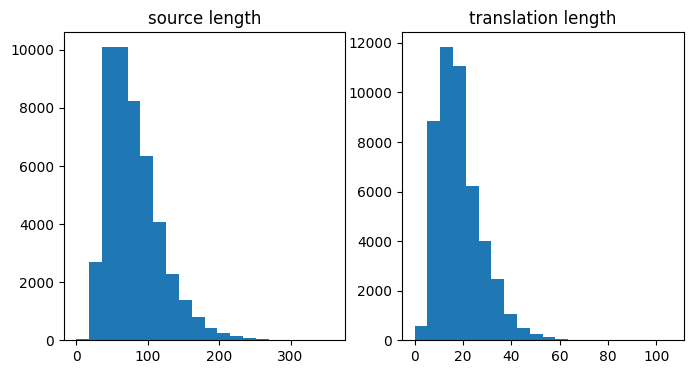

In [39]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

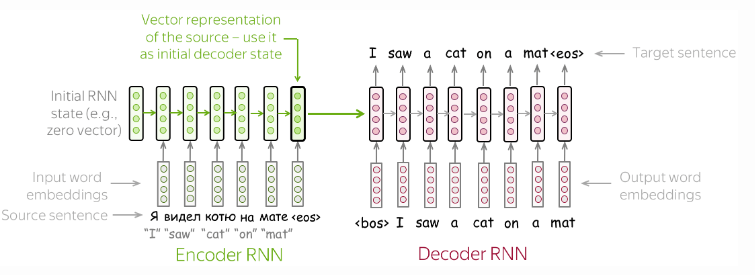

In [4]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # input & hidden states
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [11]:
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
train_inp[:3]

array(['этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .',
       'на полностью оборудованной мини - кухне можно самостоятельно готовить .',
       'номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .'],
      dtype='<U524')

In [43]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
upe red luna dist@@ pleasure dist@@ pleasure 12 book sul@@ rue swing swing wn@@ old@@ he@@ hagen ot bir@@ nearby sebastian resses heart yce renovated
equip@@ equi@@ gdynia recommended ize blan@@ taken amongst ders sales summer lively beddings originally baby watersports germany vill@@ ery ga@@ jeju kim@@ canto blan@@ gra@@
equip@@ supplies suite same ud@@ schloss achen balaton bjer@@ balaton bjer@@ zen od@@ fisherman bit@@ bit@@ stop put@@ dian castell@@ marmara eo vicin@@ lock salads


### Loss

Будем минимизировать categorical crossentropy во время обучения на данных $D$:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

$|D|$ - длина всех последовательностей, включая BOS and первые EOS токены, кроме PAD

In [4]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [ ]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

### Оценка качества: BLEU

Распространенная матрика машинного перевода - [BLEU](https://en.wikipedia.org/wiki/BLEU). Эта метрика вычисляет долю верно предсказанных n-grams. В частности, например, для n=1, 2, 3, 4 она вычисляется как геометрическое среднее со штрафом за короткие переводы.

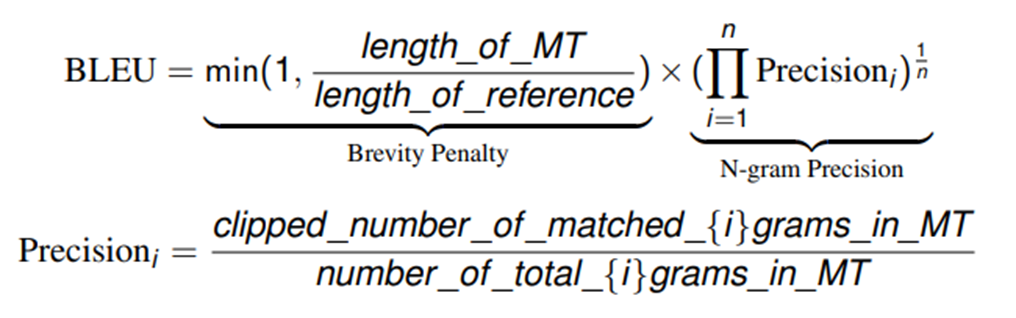

[Эволюция метрик качества машинного перевода](https://habr.com/ru/articles/745642/)

In [5]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [47]:
compute_bleu(model, dev_inp, dev_out)

0.0020547314381909815

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [17]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

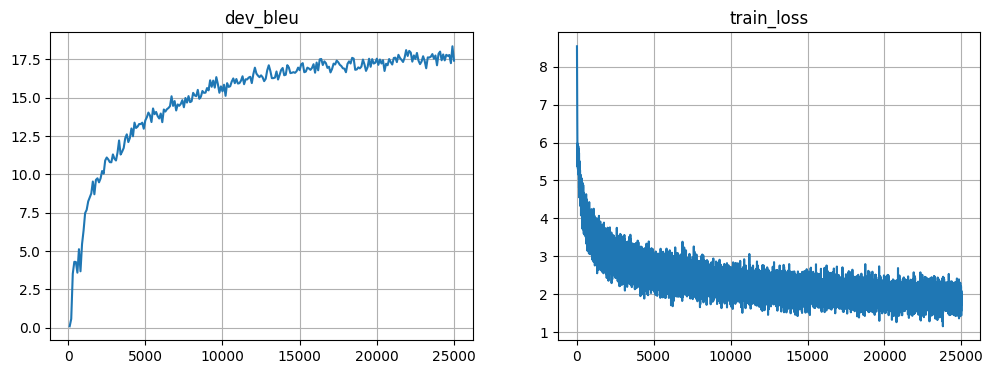

Mean loss=1.830


100%|██████████| 25000/25000 [28:03<00:00, 14.85it/s]


In [49]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [50]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [51]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в в@@ а@@ н@@ н@@ о@@ й к@@ о@@ м@@ н@@ а@@ т@@ е с в@@ а@@ н@@ н@@ о@@ й п@@ р@@ е@@ д@@ о@@ с@@ т@@ а@@ в@@ л@@ я@@ е@@ т@@ с@@ я ф@@ е@@ н .
featuring a bath , the bathroom also comes with a hairdryer .

н@@ а т@@ е@@ р@@ р@@ и@@ т@@ о@@ р@@ и@@ и м@@ о@@ ж@@ н@@ о с@@ ы@@ г@@ р@@ а@@ т@@ ь в д@@ а@@ р@@ т@@ с и с@@ к@@ в@@ о@@ ш .
guests can enjoy the on - site garden and the property .

а@@ п@@ а@@ р@@ т@@ а@@ м@@ е@@ н@@ т@@ ы р@@ а@@ с@@ п@@ о@@ л@@ а@@ г@@ а@@ ю@@ т г@@ о@@ с@@ т@@ и@@ н@@ о@@ й з@@ о@@ н@@ о@@ й .
apartments also have a seating area .

г@@ о@@ с@@ т@@ и м@@ о@@ г@@ у@@ т с@@ а@@ м@@ о@@ с@@ т@@ о@@ я@@ т@@ е@@ л@@ ь@@ н@@ о п@@ р@@ и@@ г@@ о@@ т@@ о@@ в@@ и@@ т@@ ь б@@ л@@ ю@@ д@@ а н@@ а п@@ о@@ л@@ н@@ о@@ с@@ т@@ ь@@ ю у@@ к@@ о@@ м@@ п@@ л@@ е@@ к@@ т@@ о@@ в@@ а@@ н@@ н@@ о@@ й к@@ у@@ х@@ н@@ е .
guests can prepare their meals in the kitchen at the fully equipped kitchens .

к у@@ с@@ л@@ у@@ г@@ а@@ м г@@ о@@ с@@ т@@ е@@ й 2 с@@ п@@ а@@ л@@ ь@@ н@@ и и 

In [52]:
compute_bleu(model, dev_inp, dev_out)

17.4067557140932

### Attention

Добавим простой attention:

Имея последовательность $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ из encoder'а и decoder state $h^d$,

* Вычислим логиты двухслойной сеткой
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получим вероятности,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвесим состояния encoder'а с вероятностями, чтобы получить **attention**
$$ attn = \sum_t p_t \cdot h^e_t $$

[Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/).

In [6]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

### Seq2seq model + attention

Теперь можно использовать слой attention в Seq2Seq модели:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

На каждом шагу используем предыдущее состояние декодера для подсчета attention, затем приконкатенируем attention ко входам следующего слоя. T


In [7]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


### Training loop - модель с Attention


In [13]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [ ]:
model

AttentiveModel(
  (emb_inp): Embedding(8047, 64)
  (emb_out): Embedding(7800, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=7800, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [56]:
compute_bleu(model, dev_inp, dev_out)

0.0017557327082925634

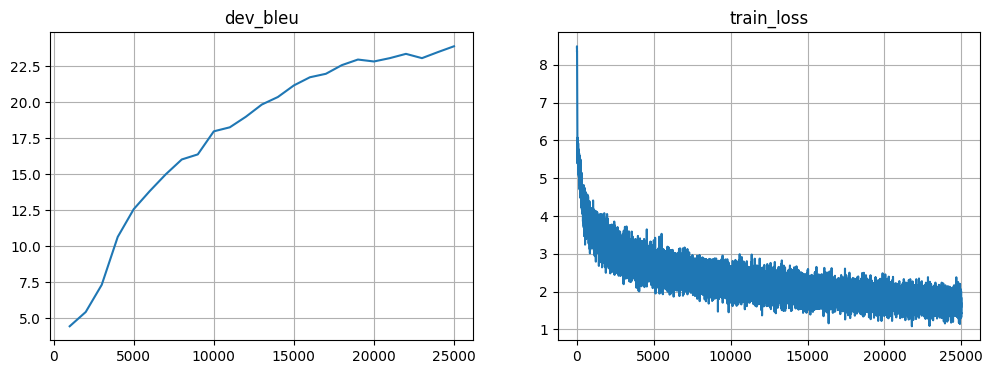

Mean loss=1.642


100%|██████████| 25000/25000 [1:18:24<00:00,  5.31it/s]


In [14]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 1000 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [15]:
compute_bleu(model, dev_inp, dev_out)

23.89110945184609

In [16]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в в@@ а@@ н@@ н@@ о@@ й к@@ о@@ м@@ н@@ а@@ т@@ е с в@@ а@@ н@@ н@@ о@@ й п@@ р@@ е@@ д@@ о@@ с@@ т@@ а@@ в@@ л@@ я@@ е@@ т@@ с@@ я ф@@ е@@ н .
the bathroom comes with a bathtub , while the bathroom is completed with a hairdryer .

н@@ а т@@ е@@ р@@ р@@ и@@ т@@ о@@ р@@ и@@ и м@@ о@@ ж@@ н@@ о с@@ ы@@ г@@ р@@ а@@ т@@ ь в д@@ а@@ р@@ т@@ с и с@@ к@@ в@@ о@@ ш .
the property has a number of the room .

а@@ п@@ а@@ р@@ т@@ а@@ м@@ е@@ н@@ т@@ ы р@@ а@@ с@@ п@@ о@@ л@@ а@@ г@@ а@@ ю@@ т г@@ о@@ с@@ т@@ и@@ н@@ о@@ й з@@ о@@ н@@ о@@ й .
the apartments will provide you with a seating area .

г@@ о@@ с@@ т@@ и м@@ о@@ г@@ у@@ т с@@ а@@ м@@ о@@ с@@ т@@ о@@ я@@ т@@ е@@ л@@ ь@@ н@@ о п@@ р@@ и@@ г@@ о@@ т@@ о@@ в@@ и@@ т@@ ь б@@ л@@ ю@@ д@@ а н@@ а п@@ о@@ л@@ н@@ о@@ с@@ т@@ ь@@ ю у@@ к@@ о@@ м@@ п@@ л@@ е@@ к@@ т@@ о@@ в@@ а@@ н@@ н@@ о@@ й к@@ у@@ х@@ н@@ е .
guests can prepare their meals in the fully equipped kitchen .

к у@@ с@@ л@@ у@@ г@@ а@@ м г@@ о@@ с@@ т@@ е@@ й 2 с@@ п@@ а@@ л@@ ь@@ 

## Что можно улучшить

* продолжить эксперименты с различными RNN юнитами: gru/lstm; более глубокие архитектуры
* Сделать encoder двунаправленным, попробовать различные attention (additive, dot-product, multi-head, ...)
* улучшить training-процесс: lr sheduling, early stopping и т.п.
* заменить greedy инференс на другие варианты


### Улучшения
1. GRU был выбран как компромисс между эффективностью и качеством. Сокращение числа гейтов (2 вместо 3 в LSTM) ускоряет обучение и снижает потребление памяти, что критично для больших моделей. При этом GRU сохраняет способность улавливать долгосрочные зависимости, что важно для перевода, где контекст распространяется на всё предложение.
2. Реализовано bidirectional RNN для более глубокого захвата контекста предложения. Двунаправленность позволяет модели анализировать контекст как слева направо, так и справа налево. Для машинного перевода это особенно важно, так как значение слов часто зависит от последующих элементов (например, согласование времён или управление глаголов). Это улучшает понимание структуры исходного текста.
3. Оптимизатор Adam заменён на AdamW для улучшения регуляризации и снижения переобучения. AdamW обеспечивает более эффективную регуляризацию за счёт разделения весового спада и обновления параметров. Это снижает риск переобучения, особенно при работе с ограниченными данными или сложными архитектурами, и способствует лучшей обобщающей способности модели.
4. Добавлен Косинусный lr-планировщик с вармапом, использя `get_cosine_schedule_with_warmup` для лучшей сходимости. Warmup предотвращает нестабильность на начальных этапах обучения, постепенно увеличивая скорость. Косинусное расписание плавно снижает lr к концу обучения, что помогает модели достичь минимума потерь без "застревания" в локальных оптимумах. Это улучшает сходимость и итоговое качество.
5. Внедрён механизм early stopping для предотвращения переобучения при отсутствии улучшений, что позволяет сохранить оптимальную модель. Остановка при отсутствии улучшений на валидации предотвращает переобучение и экономит вычислительные ресурсы. Метод гарантирует, что сохраняется наилучшая версия модели, что особенно важно при длительном обучении.
6. Увеличен размер словаря токенизатора (8000 -> 10000).  Расширение словаря до 10 000 токенов снижает долю OOV-слов (Out-of-vocabulary), улучшая покрытие редких терминов и морфем.
7. Вместо стандартного greedy-инференса реализованы альтернативные стратегии сэмплирования. В частности, добавлено top_k и top_p сэмплирование с регулировкой температуры, что способствует генерации более разнообразных переводов. Greed-подход часто приводит к шаблонным и повторяющимся переводам. Top-k и nucleus-сэмплирование (top-p) с регулируемой температурой добавляют контролируемую случайность, повышая разнообразие и естественность выходного текста. Например, снижение температуры делает вывод более уверенным, а повышение — креативным.
8. Добавлена фиксация сидов для воспроизводимости. Воспроизводимость — ключевой аспект научного подхода. Фиксация сидов позволяет точно оценить влияние изменений, исключив влияние случайности на результаты экспериментов.

Все модификации, направленные на улучшение обучения, позволили увеличить качество перевода с 24 до 27 BLEU. Данные модификации основаны на моем предыдущем опыте обучения моделей. 

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Фиксируем сиды
set_seed(42)

In [7]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.hid_size = hid_size

        # Энкодер теперь двунаправленный (выходной размер hid_size*2)
        self.enc0 = nn.GRU(emb_size, hid_size, num_layers=2, bidirectional=True, batch_first=True)
        
        # Увеличиваем размер входа для декодера (hid_size*2 -> hid_size)
        self.dec_start = nn.Linear(hid_size * 2, hid_size)
        
        # Исправляем размер входа GRUCell: (emb_size + hid_size*2)
        self.dec0 = nn.GRUCell(emb_size + hid_size * 2, hid_size)  # Было emb_size + hid_size
        
        # Attention работает с двунаправленными выходами энкодера
        self.attention = AttentionLayer(hid_size * 2, hid_size, attn_size)

    # Остальные методы без изменений
    def encode(self, inp, **flags):
        inp_emb = self.emb_inp(inp)
        enc_seq, _ = self.enc0(inp_emb)  # [batch, time, hid_size*2]
        
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1]-1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]  # [batch, hid_size*2]
        
        dec_start = self.dec_start(last_state)
        inp_mask = self.inp_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)
        
        return [dec_start, enc_seq, inp_mask, first_attn_probas]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, [batch_size]
        :return: (new_state, logits)
        """
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        
        # Compute attention context
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)
        
        # Update GRU state
        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        new_gru0_state = self.dec0(x, prev_gru0_state)

        # Generate logits and update state
        new_state = [new_gru0_state, enc_seq, enc_mask, attn_probs]
        return new_state, self.logits(new_gru0_state)

    def decode_inference(self, initial_state, max_len=100, temperature=1.0, top_k=0, top_p=0.0, **kwargs):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for _ in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            
            if temperature == 0.0:
                next_tokens = logits.argmax(dim=-1)
            else:
                logits = logits / temperature

                if top_k > 0:
                    top_k_logits, _ = torch.topk(logits, top_k, dim=-1)
                    min_topk = top_k_logits[:, -1].unsqueeze(-1)
                    logits = torch.where(logits < min_topk, torch.tensor(float('-inf')).to(logits.device), logits)
                
                if top_p > 0.0:
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                    sorted_probs = torch.softmax(sorted_logits, dim=-1)
                    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                    
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = False
                    
                    indices_to_remove = sorted_indices_to_remove.scatter(-1, sorted_indices, sorted_indices_to_remove)
                    logits = logits.masked_fill(indices_to_remove, float('-inf'))
                
                probs = torch.softmax(logits, dim=-1)
                next_tokens = torch.multinomial(probs, num_samples=1).squeeze(-1)
            
            outputs.append(next_tokens)
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, temperature=1.0, top_k=0, top_p=0.0, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(
            initial_state, 
            temperature=temperature, 
            top_k=top_k, 
            top_p=top_p, 
            **kwargs
        )
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [9]:

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

with open('train_exp.en', 'w', encoding='utf-8') as f_src,  open('train_exp.ru', 'w', encoding='utf-8') as f_dst:
  for line in open('data.txt', "r", encoding='utf-8'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train_exp.' + lang, 'r', encoding='utf-8'), open('bpe_rules.' + lang, 'w', encoding='utf-8'), num_symbols=10000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train_exp.bpe.' + lang, 'w', encoding='utf-8') as f_out:
        for line in open('train_exp.' + lang, 'r', encoding='utf-8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

data_inp = np.array(open('./train_exp.bpe.ru', 'r', encoding='utf-8').read().split('\n'))
data_out = np.array(open('./train_exp.bpe.en', 'r', encoding='utf-8').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2023,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')


inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

100%|██████████| 10000/10000 [00:09<00:00, 1109.69it/s]


inp: э@@ т@@ о@@ т о@@ т@@ е@@ л@@ ь н@@ а@@ х@@ о@@ д@@ и@@ т@@ с@@ я в ц@@ е@@ н@@ т@@ р@@ е п@@ а@@ р@@ и@@ ж@@ а , в 2 м@@ и@@ н@@ у@@ т@@ а@@ х о@@ т п@@ л@@ о@@ щ@@ а@@ д@@ и р@@ е@@ с@@ п@@ у@@ б@@ л@@ и@@ к@@ и и с@@ т@@ а@@ н@@ ц@@ и@@ и м@@ е@@ т@@ р@@ о с 5 л@@ и@@ н@@ и@@ я@@ м@@ и м@@ е@@ т@@ р@@ о и 4 а@@ в@@ т@@ о@@ б@@ у@@ с@@ н@@ ы@@ м@@ и м@@ а@@ р@@ ш@@ р@@ у@@ т@@ а@@ м@@ и .
out: this hotel is located in the centre of paris , 2 minutes from place de la r@@ é@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: н@@ а п@@ о@@ л@@ н@@ о@@ с@@ т@@ ь@@ ю о@@ б@@ о@@ р@@ у@@ д@@ о@@ в@@ а@@ н@@ н@@ о@@ й м@@ и@@ н@@ и - к@@ у@@ х@@ н@@ е м@@ о@@ ж@@ н@@ о с@@ а@@ м@@ о@@ с@@ т@@ о@@ я@@ т@@ е@@ л@@ ь@@ н@@ о г@@ о@@ т@@ о@@ в@@ и@@ т@@ ь .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: н@@ о@@ м@@ е@@ р@@ а н@@ а@@ х@@ о@@ д@@ я@@ т@@ с@@ я п@@ о@@ д к@@ р@@ ы@@ ш@@ е@@ й и@@ л@@ и н@@ а н@@

In [10]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
batch_size = 32

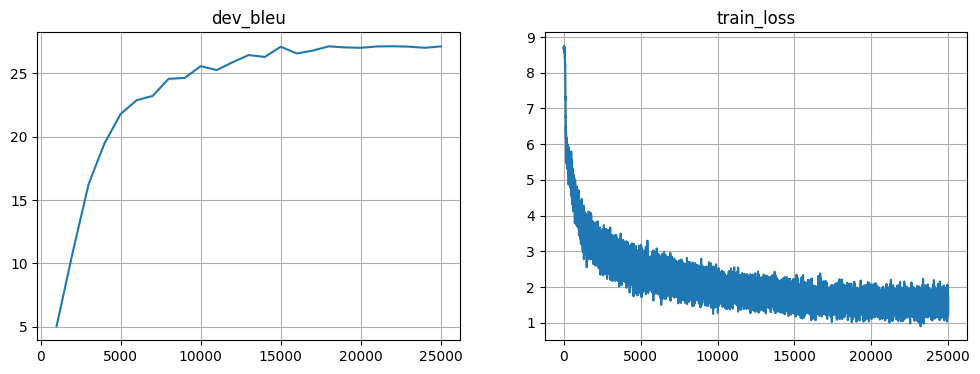

Mean loss=1.531


100%|██████████| 25000/25000 [1:26:58<00:00,  4.79it/s]

Current BLEU: 27.120, Best BLEU: 27.129
Training completed without early stopping
Final Best BLEU: 27.129


In [11]:

from transformers import get_cosine_schedule_with_warmup

# Добавляем переменные для early stopping
best_bleu = 0.0
no_improvement_steps = 0
patience = 5  # Количество проверок без улучшения перед остановкой
model_save_path = "best_model_exp.pt"  # Путь для сохранения лучшей модели

scheduler = get_cosine_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=1000,
    num_training_steps=25000
)

for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    
    opt.step()
    scheduler.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 1000 == 0:
        current_bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, current_bleu))
        
        # Early stopping логика
        if current_bleu > best_bleu:
            best_bleu = current_bleu
            no_improvement_steps = 0
            # Сохраняем лучшую модель
            torch.save(model.state_dict(), model_save_path)
        else:
            no_improvement_steps += 1
            
        # Останавливаем если не было улучшений N проверок
        if no_improvement_steps >= patience:
            print(f"\nEarly stopping at step {step}. Best BLEU: {best_bleu:.3f}")
            # Загружаем веса лучшей модели
            model.load_state_dict(torch.load(model_save_path))
            break
            
        # Визуализация и вывод статистики
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print(f"Mean loss={np.mean(metrics['train_loss'][-10:], axis=0)[1]:.3f}", flush=True)
        print(f"Current BLEU: {current_bleu:.3f}, Best BLEU: {best_bleu:.3f}")

# После цикла (если закончили все шаги без early stopping)
if no_improvement_steps < patience:
    print("Training completed without early stopping")
    print(f"Final Best BLEU: {best_bleu:.3f}")

In [12]:
compute_bleu(model, dev_inp, dev_out)

27.119656594527363

In [13]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line.replace('@@ ', ''))
    print(trans_line.replace('@@ ', ''))
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom comes with a bath and a bidet .

на территории можно сыграть в дартс и сквош .
activities like scuba fishing and nordic yoopy issa .

апартаменты располагают гостиной зоной .
the apartment will provide you with a living area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can prepare their own meals in the fully - equipped kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
there is a double bed and a bathroom with a bath or 1 . a 1 - atm room can be found in the kitchen or washbathrooms .

ужин для гостей приготовят в ресторане ronnie ' s wings & oyster bar .
other facilities offered at the illa hotel rock sitot grill di tromälucma cetu oles mnma bt .



Загрузка модели и проверка методик сэмплирования

In [10]:
model = AttentiveModel(inp_voc, out_voc).to(device)

checkpoint = torch.load("best_model_exp.pt", map_location=device)
model.load_state_dict(checkpoint)

model.eval()

C:\Users\Rustam\AppData\Local\Temp\ipykernel_12612\1349588832.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_exp.pt", map_location=d

AttentiveModel(
  (emb_inp): Embedding(2139, 64)
  (emb_out): Embedding(9287, 64)
  (enc0): GRU(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dec_start): Linear(in_features=256, out_features=128, bias=True)
  (dec0): GRUCell(320, 128)
  (logits): Linear(in_features=128, out_features=9287, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=256, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [12]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], temperature=0.7, top_k=50, top_p=0.8)[0]):
    print(inp_line.replace('@@ ', ''))
    print(trans_line.replace('@@ ', ''))
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom is fitted with a bath and a hairdryer .

на территории можно сыграть в дартс и сквош .
an array of activities in the grounds and the old town can be exploby .

апартаменты располагают гостиной зоной .
the apartments feature a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can prepare their own meals in the fully - equipped kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
this apartment features 2 bedrooms and 1 double and a bathroom with a bath and a stove and a microwave .

ужин для гостей приготовят в ресторане ronnie ' s wings & oyster bar .
guests can also order dishes at the on - site restaurant or at the schtene ’ s restaurant & restaurant .

